In [1]:
# put absolute path here
DATA_DIR = r"C:\Users\Joanna\NLP_homeworks\json"
# put elastic search address here
ELASTIC_ADDRESS = "http://localhost:9200/"

In [2]:
# making usage of my helper .py file in jupyter environment on any computer
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from file_utils import *
data_manager = DataManager(DATA_DIR)

In [3]:
from elasticsearch_dsl import connections, InnerDoc, Text, DocType, Date, Keyword, Nested, Index, analyzer

In [4]:
connections.create_connection(hosts=['localhost'], timeout=20)
Index(name='judgments').delete()

{'acknowledged': True}

In [5]:
put_body = {
  "settings": {
    "analysis": {
      "analyzer": {
        "my_morfologik": { 
          "type": "custom",
          "tokenizer": "standard",
          "filter": [
            "lowercase",
            "morfologik_stem"
          ]
        }
      }
    }
  },
  "mappings": {
    "doc": {
      "properties": {
        "text_field": {
          "type": "text",
          "analyzer": "my_morfologik"
        },
        "date_field": {
          "type": "date",
        },
        "signature": {
          "type": "keyword"
        },
        "judges": {
          "type": "keyword"
        }
      }
    }
  }
}
import requests
requests.put(ELASTIC_ADDRESS+"judgments", json=put_body)

<Response [200]>

In [6]:
class Judgment(DocType):
    text_field = Text()
    date_field = Date()
    signature = Keyword()
    judges = Keyword()
        
    class Meta:
        index = 'judgments'     

In [7]:
generator = data_manager.judgments_generator(year=2009)
while True:
    try:  
        content = generator.__next__()
        text = content["textContent"]
        date = content["judgmentDate"]
        signature = content["id"]
        judges = content["judges"]
        
        Judgment(text_field=text, date_field=date, signature=signature, judges=[judge['name'] for judge in judges]).save()
    except StopIteration:
        print("Processing finished")
        break

Processing finished


In [8]:
from elasticsearch_dsl import Search
query = Search().query("match", text_field="szkodę")
query.execute()
print("Total number of judgments cotaining damage word is: %d" % query.count())

Total number of judgments cotaining damage word is: 733


In [13]:
query = Search().query("match_phrase", text_field="trwały uszczerbkowi na zdrowiu")                                                                                                
query.execute()
print("Total number of judgments cotaining phrase 'trwały uszczerbek na zdrowiu': %d" % query.count())

Total number of judgments cotaining phrase 'trwały uszczerbek na zdrowiu': 6


In [10]:
# because span near span term does not get analysed
# but still better than just match phrase with slope
query = Search().query("span_near", 
                       clauses=[
                           {"span_term":{"text_field":"trwały"}},
                           {"span_term":{"text_field":"uszczerbek"}},
                           {"span_term":{"text_field":"na"}},
                           {"span_term":{"text_field":"zdrowie"}}
                        ],
                       slop=2,
                       in_order= True)
query.execute()
print("Total number of judgments containing phrase 'trwały uszczerbek na zdrowiu' with span: %d" % query.count())

Total number of judgments containing phrase 'trwały uszczerbek na zdrowiu' with span: 7


In [11]:
# shard_size = 100 determines that coordinator asks each shard for 100 best judges
query = Search()
query.aggs.bucket('best', 'terms', field='judges', size=3, shard_size=100)

for judge in query.execute().aggregations.best:
    print(judge)

{'key': 'Andrzej Niwicki', 'doc_count': 234}
{'key': 'Sylwester Kuchnio', 'doc_count': 225}
{'key': 'Barbara Bettman', 'doc_count': 221}


[398, 325, 405, 399, 357, 355, 426, 232, 377, 401, 420, 442]



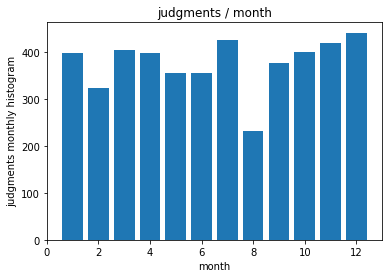

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

query = Search()
query.aggs.bucket('judgments', 'date_histogram', field='date_field', interval='month')

buckets = [bucket.doc_count for bucket in query.execute().aggregations.judgments['buckets']]    
print(buckets)

plt.bar([x for x in range(1, 13)], buckets)

plt.title('judgments / month')
plt.xlabel('month')
plt.ylabel('judgments monthly histogram')
print("")